# CNN1

Because there is a lot of duplicated code across my various modelling notebooks for CNN1, VGG16, and ResNet50 to set up the environment, the data, and the models, many of the explanations are duplicated as well. I did this because even though the notebooks would ideally be read in order, I wanted to make each notebook a standalone document.

## 1.1 Google Colab Setup - When running locally, skip ahead to Local Setup

I ran this notebook in Google Colab Pro in the Python3 environment using a GPU runtime.

At the time of writing, it was necessary to update the `tensorflow_datasets` package to import the dataset correctly. After running this cell, restart the runtime so that the new version of this package is loaded.

In [ ]:
!pip install tensorflow_datasets==4.2.0

The following cells have been adapted from code located [here](https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228)

Ensure we're connected to a GPU

In [ ]:
from tensorflow.test import gpu_device_name

device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Mount Google Drive

In [ ]:
from google.colab import drive 

# Default location for the drive
ROOT = "/content/drive"  
# Print content of ROOT
print(ROOT)                 

# Mount Google Drive at /content/drive
drive.mount(ROOT)           

Change to the directory containing project files

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/BrainStation Capstone Project/capstone'

%cd '{PROJECT_PATH}'

This cell imports `pcamlib.py` into Google Colab

In [ ]:
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

For best performance, upload the `tensorflow_datasets` folder created by running the CLI command `tfds build patch_camelyon` locally to the folder specified in `pcam_path` within your Google Drive. 

If you have not done this step, running this cell will instead download the dataset automatically and save it to the virtual disk in Google Colab. When not using Colab Pro, I have found that I quickly ran out of disk space with this method. Note that this step can take 10-20 minutes while the files are downloaded and processed. If you have uploaded the dataset already, this cell should run almost instantly, and print the information about the dataset in the `tfds.core.DatasetInfo()` object.

In [ ]:
pcam_path = '/content/drive/MyDrive/BrainStation Capstone Project/tensorflow_datasets'
pcam, pcam_info = pcamlib.load_pcam(data_dir=pcam_path)

---

## 1.2 Local Setup - Skip these cells when running in Google Colab

In [6]:
# pcamlib.py is my library of helper functions
import pcamlib

This cell should automatically download the `patch_camelyon` dataset into `~/tensorflow_datasets/patch_camelyon` if it's not already installed (7.48 GB). If there are any issues, run the CLI command `tfds build patch_camelyon` first to install. If the dataset already exists in this location, this cell should print the dataset info almost instantly. If you selected a different location to install the dataset, update the `data_dir` parameter with the location of the dataset you selected.

In [7]:
# Load dataset and dataset info 
pcam, pcam_info = pcamlib.load_pcam()

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/Users/jaredlauer/tensorflow_datasets/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits=

----

## 1.3 Finish Setup - Always run these cells

In [8]:
# Import datascience packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import tensorflow packages
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

To get started with this dataset, I adapted the code from this [article](https://geertlitjens.nl/post/getting-started-with-camelyon/) written by Geert Litjens, one of the authors of the dataset.

I used his code for the `train_pipeline`, `valid_pipeline`, and `test_pipeline`, which load the train, validation, and test sets and prepare them for modelling. I also make use of his function `convert_sample`. This function extracts each image and its corresponding label from the dataset, converts each image to a TensorFlow `tf.float32` datatype, then performs one-hot encoding on the labels and converts them to `tf.float32` as well.

By default, the batch size for the training set is 64, and 128 for the test and validation sets.

In [9]:
# Create generator "pipelines" for train, validation and test sets.
# Default batch sizes of 64 for the train set and 128 for validation and test sets to speed up calculations
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

---

## 2.0 Training the Model

> If you are not training this model and are loading it from a file, skip ahead to 2.2 Loading the Model

I used Geert Litjens CNN layer architecture as a starting point. It resembles a VGG16 architecture because it has three sets of two Convolutional layers followed by a single Max Pooling layer, followed by a Flattening layer and two Dense layers before the final Dense layer which outputs the class predictions. I kept the `relu` activation function, `valid` padding and 3x3 `kernel_size`, because in my research these all seemed like fairly standard hyperparameters in CNNs, and my general philosophy was not to change anything unless I had a particuarly good reason to. 

I changed the optimizer to `Adam` from `SGD` because I found that `SGD` did not perform very well, and `Adam` is an extremely popular choice in CNNs because of its effectiveness. 

The other change I made to this architecture was adding 25% Dropout layers after each Convolutional and Dense layer, because the first iteration of the model started overfitting extremely quickly after the first epoch. Increasing the level of dropout didn't make a major difference in my experience.

I also experimented with adding additional Convolutional and Dense layers near the end of the network, but this didn't improve performance significantly. I suspect this is because the dimensionality of the features gets very low at the end of the network (8x8), and adding more layers doesn't make much impact because they don't have enough information to work with. 

I tried different learning rates as well, but this didn't make a significant impact either.

Overall, I found that optimizing this network myself was very difficult. Due to the random nature of weight initialization and training image shuffling, each training run gave different results, and it was challenging to find ways to improve the performance of the network and be confident that changes weren't simply due to random chance. I attempted to train each iteration 3 or more times and average the results, but this quickly became very time-consuming and didn't appear to be worth the effort. I think a better way to improve the improve the performance on this dataset is to make more macro scale changes such as experimenting with different transfer learning models, grayscaled versions of the images, data augmentation, and the like. 

In [32]:
# Instantiate model object
cnn = Sequential()

# Images are 96x96 px, in RGB so there are 3 channels
image_shape = (96, 96, 3)

# Adding convultional layers to the model 
# It was important to add dropout layers after each convolutional layer to reduce overfitting
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=image_shape))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))

# Add a max pool layer to reduce the dimensions of the feature maps
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))

# Repeating this architecture two more times
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
     
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))

# Flatten the data to prepare for dense layers
cnn.add(Flatten())
        
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.25))

cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.25))

# Final Dense layer to make class predictions
cnn.add(Dense(2, activation='softmax'))
        
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
dropout (Dropout)            (None, 94, 94, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 92, 92, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 44, 44, 32)        0

CNN1 only has around 1.15 million parameters, all of them trainable. While this sounds like a lot, as we will see when beginning transfer learning with VGG16 and ResNet50, this is actually relatively small for a CNN architecture.

We compile the model with the `Adam` optimizer as it is one of the most commonly used and most effective optimizers when using CNNs for image classification. We use a `categorical_crossentopy` loss function and track the accuracy of the train and validation set throughout the training process.

In [ ]:
cnn.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Finally, we create an early stopping callback function which will stop the training process early if the validation loss fails to decrease over the specified number of epochs. This allows us to set the number of training epochs to a large number without fear of wasting time going through all the epochs if they aren't improving the results.

I experimented with different values for the patience, and 8 may be slightly too long for optimal results, but I wanted to see if the networks would improve at all if left to train for a longer period of time. 

In [ ]:
# Add early stop callback to prevent the model from overfitting, or running too long
# This will stop the training early if the validation loss doesn't not decrease within 8 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=8, mode='min', verbose=1)

This cell trains the model, and it's important to save the output into a variable called `history` so the training accuracy and loss history can be plotted later. I selected 30 epochs as an arbitrarily large number, and rely on the early stopping threshold to determine how long the model is trained. 

`steps_per_epoch` is simply the size of the training set divided by the batch size (262144 / 64) which ensures the entire training set is covered in each epoch.

Similarly, `validation_steps` is the size of the validation set divided by the batch size of the validation set (32768 / 128) to ensure the entire validation set is tested.

If changing the batch size, it's important to update these variables accordingly.

In [ ]:
%%time
history = cnn.fit(train_pipeline,
                   validation_data=valid_pipeline,
                   verbose=1, epochs=30, steps_per_epoch=4096, validation_steps=256,
                   callbacks=[early_stop])

Here, I save the history as a pandas dataframe for easier exporting to .csv and plotting.

In [ ]:
# Save the history of the model to a pandas dataframe
hist_df = pd.DataFrame(history.history)

---

## 2.1 Saving the Model

Because the training process can take a long time, it's a good idea to save the trained model, the training history, and the model predictions to external files. 

In [ ]:
# Save the fitted model to a file
cnn.save('data/models/cnn1')

In [ ]:
# Save the history of the model to a csv
pcamlib.save_history(hist_df, 'data/models/history/cnn1_history.csv')

In general, I leave `save=False` when running these cells to avoid accidentally overwriting files. Simply change this to `save=True`, and consider changing the filepath, when you want to save these results.

On average, calculating `y_proba` takes around 40 seconds in Colab.

In [ ]:
%%time
y_proba = pcamlib.generate_y_proba(cnn, test_pipeline, class_1=False, save=False, filepath='data/models/y_proba/cnn1_y_proba.csv')

---

## 2.2 Loading the Model

Here, you can load the model, it's history, and predictions from files by running these cells.

In [10]:
# Load the model from a file
cnn = load_model("data/models/cnn1/")

In [11]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/cnn1_history.csv')

In [12]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/models/y_proba/cnn1_y_proba.csv')

This cell extracts the ground truth labels from the test set and saves them as `y_true`

In [13]:
%%time

# Create a list of the true labels for the test set
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 23.4 s, sys: 1.97 s, total: 25.4 s
Wall time: 5.08 s


---

## 3.0 Evaluating the Model

I am evaluating the outputs from a trained model I've loaded from section 2.2 above.

If you trained a model in this notebook, the results will likely be very different from what I'm describing in the markdown cells.

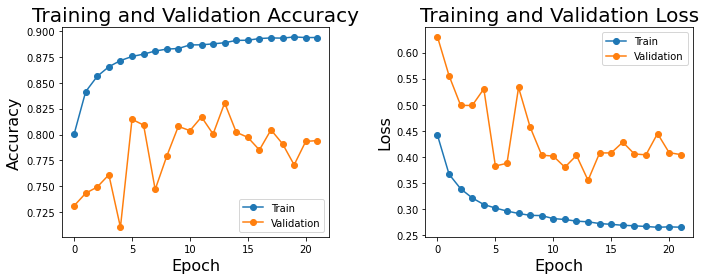

In [34]:
# Plot the training and validation Accuracy and Loss
pcamlib.plot_history(hist_df, save=True, filepath='data/plots/cnn1_acc_loss.png')

This model does show some overfitting, but the training accuracy seems to be levelling out. The validation accuracy and loss is fairly erratic, and to optimize the performance of this model in the future it may make sense to use Model Checkpointing to save the best version of the model which in this case looks to be around epoch 13. 

This cell makes predictions based on `y_proba` with the decision threshold set to 50% by default, but this can be adjusted by specifying a different value between 0 and 1 in the `threshold` parameter.

In [15]:
%%time

# Get predictions from y_proba. Default threshold of 0.5, meaning predicts positive class if >= 50% certainty of class 1 
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 11.7 ms, sys: 6.52 ms, total: 18.2 ms
Wall time: 18.9 ms


Now that we've calculated the predictions of this model, we can evaluate it on its test accuracy, positive class recall, and AUC.

In [16]:
%%time

# Calculate accuracy of the predictions on the test set
pcamlib.print_test_accuracy(y_true, y_pred)

0.787078857421875
CPU times: user 3.5 ms, sys: 3.13 ms, total: 6.63 ms
Wall time: 5.25 ms


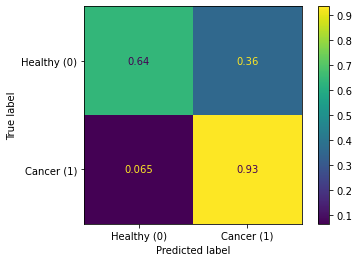

In [17]:
# Plot the confusion matrix
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True, save=True, filepath='data/plots/cnn1_cf_matrix.png')

In [18]:
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.9072    0.6398    0.7504     16391
           1     0.7216    0.9345    0.8144     16377

    accuracy                         0.7871     32768
   macro avg     0.8144    0.7871    0.7824     32768
weighted avg     0.8144    0.7871    0.7824     32768



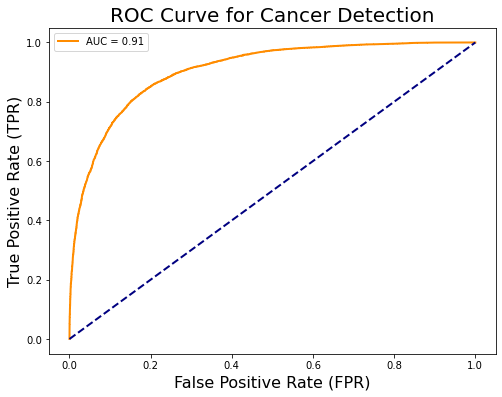

Area under curve (AUC):0.9057863555235096


In [19]:
# Plot the receiver operating characteristic curve
pcamlib.plot_roc_curve(y_true, y_proba, save=True, filepath='data/plots/cnn1_roc.png')

This model achieved a test accuracy of 78.7%, a positive class recall of 93.45%, and an AUC of 0.906.

Even though the test accuracy is slightly low, this model outperformed that pathologist benchmark on both recall and AUC which is very good to see. 

Another way to evaluate this model is to look at the number of images which were predicted to contain healthy tissue, because these would be discarded during the pre-screening process and is a measure of how much we've reduced the workload of the pathologists. An easy way to do this is to subtract the number of nonzero values from the test set, which will tell us exacly how many images were predicted to contain healthy tissue, and convert this into a percentage of the test set.

In [20]:
pcamlib.print_workload_reduction(y_pred)

35.2783203125%


We've reduced the pathologist's workload by 35.3% while only missing around 6.5% of the images containing cancer.

In summary:

|                     | Pathologist  | CNN1   |
|---------------------|--------------|--------|
| AUC                 | 0.810 (mean) | 0.906  |
| Recall              | 62.8%        | 93.5%  |
| Test Accuracy       | --           | 78.7%  |
| Workload Reduced By | --           | 35.3%  |

Finally, let's look at some of the images which are misclassified by this model. Note that to see a different selection of images, you can set `image_index` to start the search from your desired place in the test set (e.g. `image_index = 29` to start from image 29).

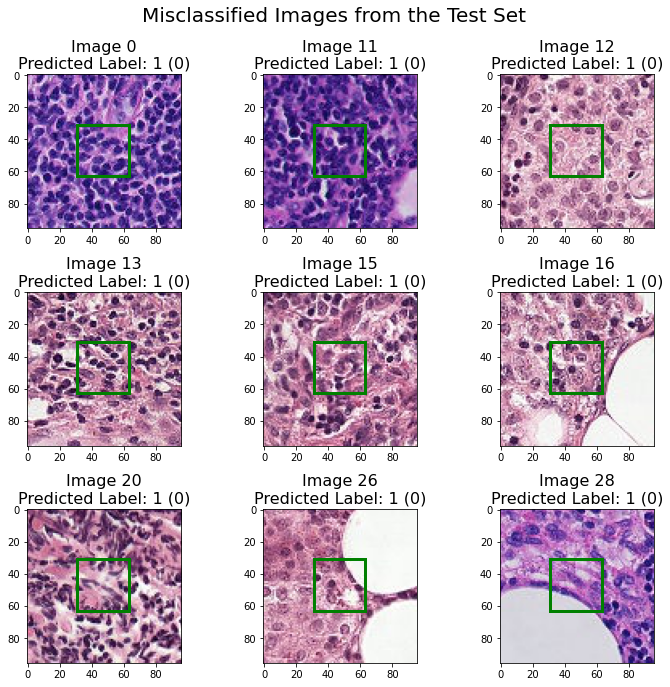

In [31]:
# Show a sample of images that were misclassified
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)

One of the most difficult tasks in this project is interpreting these misclassified images, because it takes years of specialized training as a pathologist to differentiate cancer tissue from healthy lymph node tissue. 

However, I have two hypotheses for why these images may be misclassified:
- First, and this applies to all of the images in general, because the class labelling is dependent on the presence of cancer in the central region of the image outlined by the green box, the model may be making decisions based on tissue outside of that area which may be cancerous, but doesn't contribute to the class label.
- Secondly, because these are thin cross sections of lymph nodes, there are often large areas of white space which represent the edges, or empty spaces inside the lymph nodes. This gives the model less information to work with, and their predictive ability likely suffers.